In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = '/content/drive/MyDrive/webb lab DL/peak by cell matrices/da_peaks_data'
# ncols=5038
females_data = pd.read_csv(f"{data_path}/neurons_F_dapeaks_X.csv", header=0)
males_data = pd.read_csv(f"{data_path}/neurons_M_dapeaks_X.csv", header=0)


In [4]:
female_labels = pd.read_csv(f"{data_path}/labels_neurons_F_dapeaks_chrX.csv", header=0)
male_labels = pd.read_csv(f"{data_path}/labels_neurons_M_dapeaks_all.csv", header=0)



In [5]:
# females_data = females_data.T
# males_data = males_data.T

female_labels.shape,male_labels.shape

((11420, 1), (12316, 1))

In [6]:
females_data.shape, males_data.shape


((11420, 39), (12316, 39))

In [7]:
# females_data = females_data.loc[:, (females_data != 0).any(axis=0)]
# males_data = males_data.loc[:, (males_data != 0).any(axis=0)]
# females_data.shape

In [8]:
males_data.shape

(12316, 39)

In [9]:
# print(encoded_f_labels)
# codes = {'A':1,'Y':0}
# encoded_f_labels = female_labels['x'].map(codes)
# encoded_m_labels = male_labels['x'].map(codes)
# one_hot_encoded_female_labels = pd.get_dummies(female_labels, columns = ['x'])
# one_hot_encoded_male_labels = pd.get_dummies(male_labels, columns = ['x'])

# one_hot_encoded_female_labels
#one_hot_encoded_male_labels.shape

encoded_f_labels = np.where(female_labels == 'A', 1, 0)
encoded_m_labels = np.where(male_labels == 'A', 1, 0)


In [10]:
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 9.8 MB/s eta 0:00:00


In [11]:
# This code is from: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

  

In [12]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1, l1_l2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def make_model(X_train, Y_train, X_test, Y_test,X_M,Y_M):

  # X_train = np.asarray(X_train).astype(np.int32)
  model = tf.keras.models.Sequential()
  # model.add(Dense(8192,  input_shape=(5038,), activation="leaky_relu", kernel_regularizer=l1_l2())) #CHANGE AS NUMBER OF FEATURES CHANGES
  # model.add(Dropout(0.3))
  # model.add(Dense(4096, input_shape=(8192,), activation="leaky_relu", kernel_regularizer=l1_l2()))
  # model.add(Dropout(0.3))

  
  #model.add(Dense(2048, input_shape=(5038,), activation="leaky_relu", activity_regularizer=l1_l2(0.01,0.01)))
  # model.add(Dense(5038, activation="relu", activity_regularizer=l1_l2(0.01,0.01)))
  # model.add(Dense(512, input_shape=(5038,), activation="relu"))
  # # model.add(Dropout(0.2))
  # model.add(Dense(128, input_shape=(512,),  activation="relu", activity_regularizer=l1_l2(0.1,0.1)))
  # model.add(Dropout(0.3))
  # model.add(Dense(64, input_shape=(128,), activation="leaky_relu"))
  # model.add(Dropout(0.4))
  # model.add(Dense(2, input_shape=(64,), activation='sigmoid'))

  model.add(Dense(10,  activity_regularizer= l1_l2(0.1, 0.1),kernel_regularizer=tf.keras.regularizers.L1(0.1),activation='LeakyReLU'))
  model.add(Dropout(0.5))

 
  model.add(Dense(10,  activation='LeakyReLU'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))

 
  model.compile( loss= tf.keras.losses.categorical_crossentropy,
                  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                  metrics = ['accuracy',f1_m,precision_m, recall_m])
  
  model.fit(X_train, Y_train, batch_size=64, epochs=10, verbose=1)
  # Fits the explainer

  #explainer = shap.Explainer(model.predict, X_test)
  # Calculates the SHAP values - It takes some time
  #shap_values = explainer(X_test)
  # shap.summary_plot(shap_values[:,:,1],plot_type = 'bar')
  #loss, accuracy, f1_score, precision, recall = model.evaluate(X_train, Y_train)
  #print("Training statistics- loss: ", loss, " accuracy: ", accuracy)
  test_loss, test_acc, f1_score, precision, recall = model.evaluate(X_test, Y_test)
  print("Testing statistics on females- loss: ", test_loss, " accuracy: ", test_acc)
  predictions = model.predict(X_test)
  
  test_loss_M, test_acc_M, f1_score, precision, recall = model.evaluate(X_M, Y_M)
  
  print("Testing statistics on males- loss: ", test_loss_M, " accuracy: ", test_acc_M)
  male_predictions = model.predict(X_M)
  
  return predictions,male_predictions
  

def plot_confusion_matrix(Y_predictions, Y_true):
  confmat_F = confusion_matrix(Y_true, Y_predictions)
  disp = ConfusionMatrixDisplay(confusion_matrix=confmat_F)
  disp.plot()


In [13]:
X_M = males_data
Y_M = encoded_m_labels

Y_M.shape

(12316, 1)

In [14]:
# Female model
import math

#np.random.seed(107)

num_females = females_data.shape[0]
half_idx = math.ceil(0.5*num_females)

# idx = np.random.permutation(len(Y_train)) 

indices = np.arange(num_females)
np.random.shuffle(indices)
np.random.shuffle(indices)
np.random.shuffle(indices)
np.random.shuffle(indices)
print(females_data.shape,indices.shape)
females_data = females_data.iloc[indices]
encoded_f_labels = encoded_f_labels[indices]

X_train_F, X_test_F = (females_data.iloc[:half_idx, :]), (females_data.iloc[half_idx:, :])
print(X_train_F.shape, X_test_F.shape)
Y_train_F, Y_test_F = encoded_f_labels[:half_idx], encoded_f_labels[half_idx:]


female_predictions, male_predictions = make_model(X_train_F, Y_train_F, X_test_F, Y_test_F,X_M,Y_M)  
female_predictions = np.where(female_predictions >=0.5, 1, 0)
print(np.sum(female_predictions))

(11420, 39) (11420,)
(5710, 39) (5710, 39)
Epoch 1/10


In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.


90/90 [==============================] - 2s 2ms/step - loss: 7.1844 - accuracy: 0.5163 - f1_m: 0.3843 - precision_m: 0.3467 - recall_m: 0.4401
Epoch 2/10
90/90 [==============================] - 0s 2ms/step - loss: 6.8299 - accuracy: 0.5448 - f1_m: 0.3720 - precision_m: 0.3623 - recall_m: 0.3965
Epoch 3/10
90/90 [==============================] - 0s 2ms/step - loss: 6.4866 - accuracy: 0.5541 - f1_m: 0.3470 - precision_m: 0.3603 - recall_m: 0.3464
Epoch 4/10
90/90 [==============================] - 0s 2ms/step - loss: 6.1512 - accuracy: 0.5774 - f1_m: 0.3185 - precision_m: 0.3657 - recall_m: 0.2915
Epoch 5/10
90/90 [==============================] - 0s 2ms/step - loss: 5.8245 - accuracy: 0.5867 - f1_m: 0.2678 - precision_m: 0.3526 - recall_m: 0.2249
Epoch 6/10
90/90 [==============================] - 0s 2ms/step - loss: 5.5060 - accuracy: 0.6014 - f1_m: 0.2421 - precision_m: 0.3605 - recall_m: 0.1870
Epoch 7/10
90/90 [==============================] - 0s 2ms/step - loss: 5.1965 - accura

In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.


179/179 [==============================] - 1s 2ms/step - loss: 4.1783 - accuracy: 0.6559 - f1_m: 0.0136 - precision_m: 0.0764 - recall_m: 0.0076
Testing statistics on females- loss:  4.178285121917725  accuracy:  0.6558669209480286
385/385 [==============================] - 1s 2ms/step - loss: 4.1078 - accuracy: 0.3583 - f1_m: 0.0031 - precision_m: 0.0519 - recall_m: 0.0016
Testing statistics on males- loss:  4.1078057289123535  accuracy:  0.3583143949508667
385/385 [==============================] - 1s 2ms/step
25


In [15]:
female_predictions = np.argmax(female_predictions, axis = 1)
male_predictions = np.argmax(male_predictions, axis = 1)

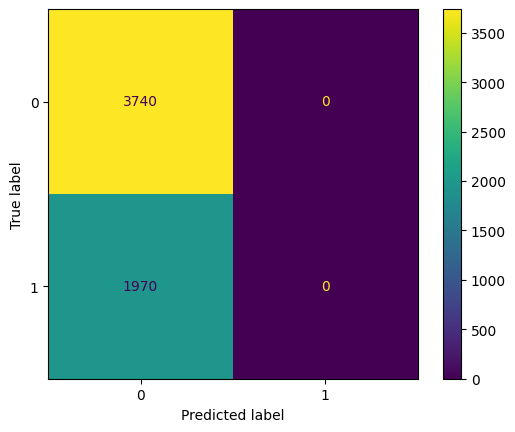

In [16]:
plot_confusion_matrix(female_predictions, Y_test_F)
 

In [17]:
print(np.sum(female_predictions==0))
print(np.sum(Y_train_F==0))
print(np.sum(Y_test_F==0))
np.sum(female_predictions == 0)


5710
3722
3740


5710

In [18]:
print(np.sum(female_predictions==1))
print(np.sum(Y_train_F==1))
print(np.sum(Y_test_F==1))
np.sum(female_predictions == 1)



0
1988
1970


0

In [19]:
np.sum(female_predictions == 1)

0

In [20]:
# femalepred_decoded = []
# for arr in female_predictions:
#   if arr[0] > arr[1]:
#     femalepred_decoded.append(0)
#   else:
#     femalepred_decoded.append(1)


In [21]:
female_labels

,x
0,A
1,A
2,A
3,A
4,A
...,...
11415,A
11416,A
11417,A
11418,A


In [22]:

# binary_f_labels = []
# for label in female_labels:
#   if label == 'A':
#     binary_f_labels.append(1)
#   else:
#     binary_f_labels.append(0)
# plot_confusion_matrix(female_labels[half_idx:], female_predictions, ['A', 'Y'])
#female_labels = female_labels.where(female_labels == 'A', 1,  0)
# female_labels

# female_labels = (female_labels == 1).astype(int)

# female_predictions = np.argmax(female_predictions, axis=1)
# female_predictions


# plot_confusion_matrix(female_predictions, fema)



In [23]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_pred_keras = female_predictions
fpr_keras, tpr_keras, thresholds_keras = roc_curve(female_labels[half_idx:], y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

ValueError: ignored

In [ ]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1_l2

def make_model_male(X_train, Y_train, X_test, Y_test,X_M,Y_M):
  model = tf.keras.models.Sequential()
  model.add(Dense(100,  activity_regularizer= l1_l2(0.1, 0.1),kernel_regularizer=tf.keras.regularizers.L1(0.1)))
  # model.add(Dropout(0.5))

  model.add(Dense(100, input_shape=(10,), activity_regularizer= l1_l2(0.01, 0.01)))
  # model.add(Dropout(0.7))

  model.add(Dense(60, input_shape=(100,), activity_regularizer= l1_l2(0.01, 0.02)))
  # model.add(Dropout(0.5))
  model.add(Dense(20, input_shape=(60,), activity_regularizer= l1_l2(0.01, 0.01)))
  # model.add(Dropout(0.5))

  model.add(Dense(2, input_shape=(20,), activation='softmax'))
  model.compile( loss= tf.keras.losses.categorical_crossentropy,
                  optimizer = tf.keras.optimizers.Adam(lr = 0.01),
                  metrics = ['accuracy'])
  model.fit(X_train, Y_train, batch_size=128, epochs=10, verbose=1)
  loss, accuracy = model.evaluate(X_train, Y_train)
  print("Training statistics- loss: ", loss, " accuracy: ", accuracy)
  test_loss, test_acc = model.evaluate(X_test, Y_test)
  print("Testing statistics- loss: ", test_loss, " accuracy: ", test_acc)
  test_loss_M, test_acc_M = model.evaluate(X_M, Y_M)
  print("Testing statistics- loss: ", test_loss_M, " accuracy: ", test_acc_M)
  # compute SHAP values
  # explainer = shap.DeepExplainer(model, X_train)
  # shap_values = explainer.shap_values(X_test)
  # shap.summary_plot(shap_values[0], plot_type = 'bar')
  



In [ ]:
# male model
import math
X_M = females_data
Y_M = one_hot_encoded_female_labels

print(X_M.shape,Y_M.shape)
num_males = males_data.shape[0]
half_idx = math.ceil(0.5*num_males)

# idx = np.random.permutation(len(Y_train)) 

indices = np.arange(num_males)
np.random.shuffle(indices)
np.random.shuffle(indices)
print(males_data.shape,indices.shape)
males_data = males_data.iloc[indices]
encoded_m_labels = encoded_m_labels[indices]

X_train_F, X_test_F = (males_data.iloc[:half_idx, :]), (males_data.iloc[half_idx:, :])
print(X_train_F.shape, X_test_F.shape)
Y_train_F, Y_test_F = one_hot_encoded_male_labels[:half_idx], one_hot_encoded_male_labels[half_idx:]

print(Y_train_F.shape,Y_train_F.shape)
make_model_male(X_train_F, Y_train_F, X_test_F, Y_test_F,X_M,Y_M) #TODO: BUG- the dimensions of the data and labels are not matching

